In [1]:
# global packages
%matplotlib inline
import tensorflow as tf
import numpy as np
import scipy.io
import matplotlib.pyplot as plt
from os import path

/home/berti/anaconda2/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


In [2]:
assert tf.__version__=='1.0.0', ('You should use Tensorflow 1.0.0')

In [3]:
# local packages
import sys
sys.path.append('../')
from src.convolutional import *

In [4]:
# net to import
net_path = '../pretrained/xc_conv5_32c_s4_e40.mat'
# this is defined manually and should reflect the network to import
conv_stride = np.array([2,1,1,1,1])
filtergroup_yn = np.array([0,1,0,1,1], dtype=bool)
bnorm_yn = np.array([1,1,1,1,0], dtype=bool)
relu_yn = np.array([1,1,1,1,0], dtype=bool)
pool_stride = np.array([2,1,0,0,0]) # 0 means no pool
pool_sz = 3
bnorm_adjust = True

assert len(conv_stride) == len(filtergroup_yn) == len(bnorm_yn) == len(relu_yn) == len(pool_stride), ('These arrays of flags should have same length')
assert all(conv_stride) >= True, ('The number of conv layers is assumed to define the depth of the network')
num_layers = len(conv_stride)

In [5]:
# read mat file from path
mat = scipy.io.loadmat(net_path)
## This is for .mat files saved with --v7.3
# import h5py
# net_file = h5py.File(net_path, 'r')
# data = f.get('...') 
net = mat.get('net')

In [6]:
# organize parameters to import
params = net['params']
params = params[0][0]
params_names = params['name'][0]
params_names_list = [params_names[p][0] for p in xrange(params_names.size)]
params_values = params['value'][0]
params_values_list = [params_values[p] for p in xrange(params_values.size)]

In [7]:
# placeholders for search region crop X and exemplar crop Z
X = tf.placeholder(tf.float32)
net_x = tf.expand_dims(X, 0)
# Z = tf.placeholder(tf.float32)
# net_z = tf.expand_dims(X, 0)

# get all parameters matching the codename (there should be only one)
def find_params(x, params):
    matching = [s for s in params if x in s]
    assert len(matching)==1, ('Ambiguous param name found')    
    return matching

# loop through the flag arrays and re-construct network, reading parameters of conv and bnorm layers
for i in xrange(num_layers):
    # conv
    conv_W_name = find_params('conv'+str(i+1)+'f', params_names_list)[0]
    conv_b_name = find_params('conv'+str(i+1)+'b', params_names_list)[0]
    conv_W = params_values_list[params_names_list.index(conv_W_name)]
    conv_b = params_values_list[params_names_list.index(conv_b_name)]
    # batchnorm
    if bnorm_yn[i]:
        bn_beta_name = find_params('bn'+str(i+1)+'b', params_names_list)[0]
        bn_gamma_name = find_params('bn'+str(i+1)+'m', params_names_list)[0]
        bn_moments_name = find_params('bn'+str(i+1)+'x', params_names_list)[0]
        bn_beta = params_values_list[params_names_list.index(bn_beta_name)]
        bn_gamma = params_values_list[params_names_list.index(bn_gamma_name)]
        bn_moments = params_values_list[params_names_list.index(bn_moments_name)]
        bn_moving_mean = bn_moments[:,0]
        bn_moving_variance = bn_moments[:,1]**2 # saved as std in matconvnet
    else:
        bn_beta = bn_gamma = bn_moving_mean = bn_moving_variance = []
    
    # set up conv "block" with bnorm and activation 
    net_x = set_convolutional(net_x, conv_W, np.swapaxes(conv_b,0,1), conv_stride[i], \
                        bn_beta, bn_gamma, bn_moving_mean, bn_moving_variance, \
                        filtergroup=filtergroup_yn[i], batchnorm=bnorm_yn[i], activation=relu_yn[i], \
                        scope='conv'+str(i+1), reuse=False)
    
    # add max pool if required
    if pool_stride[i]>0:        
        net_x = tf.nn.max_pool(net_x, [1,pool_sz,pool_sz,1], strides=[1,pool_stride[i],pool_stride[i],1], padding='VALID', name='pool'+str(i+1))


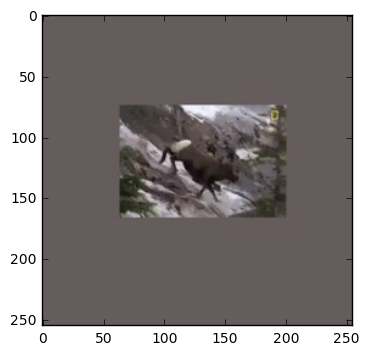

In [8]:
# test the layer
root_path = '/home/berti/ILSVRC2015_crops_90/Data/VID/train'
video_path = 'b/ILSVRC2015_train_00234012'
crop_x = '000030.01.crop.x.jpg'
crop_z = '000019.01.crop.z.jpg'
im_x = plt.imread(path.join(root_path, video_path, crop_x))
im_z = plt.imread(path.join(root_path, video_path, crop_z))
plt.imshow(im_x)

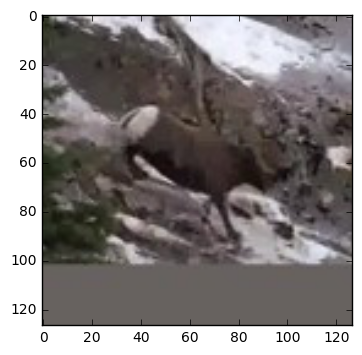

In [9]:
plt.imshow(im_z)

In [10]:
# evaluate the network
with tf.Session() as sess:
    test_writer = tf.summary.FileWriter('./logs', sess.graph)
    sess.run(tf.global_variables_initializer())
    out = sess.run(net_x, feed_dict={X: im_x})

(1, 49, 49, 32)
0.20613
3.76728
-2.9397


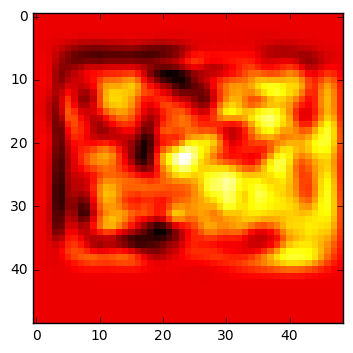

In [11]:
# check the output
print out.shape
print np.mean(out)
print np.max(out)
print np.min(out)
plt.imshow(out[0,:,:,0], cmap='hot', interpolation='none')